In [86]:
#Importing the libraries
from nsepy import get_history as stock_hist
import datetime as dt
from matplotlib import pyplot as plt
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import json

In [87]:
def read_json(file_path):
    with open(file_path, "r") as f:
        return json.load(f)

In [88]:
def date_parser(dt):
    dt = dt.split(',')
    year = int(dt[0])
    month = int(dt[1])
    day = int(dt[2])
    return year, month, day

In [89]:
config_file = read_json('config.json')
# print (config_file['symbol'])
# print (config_file['train_start_date'])
# print (config_file['train_end_date'])
# print (config_file['test_start_date'])
# print (config_file['test_end_date'])

In [91]:
symbol = config_file['symbol']

y, m, d = date_parser(config_file['train_start_date'])
train_start_date = dt.datetime(y,m,d)

y, m, d = date_parser(config_file['train_end_date'])
train_end_date = dt.datetime(y,m,d)

y, m, d = date_parser(config_file['test_start_date'])
test_start_date = dt.datetime(y,m,d)

y, m, d = date_parser(config_file['test_end_date'])
test_end_date = dt.datetime(y,m,d)

n_step = int(config_file['n_step']) #number of step or values for feature

date_col = config_file['date_col'] # date column

feature_col_1 = config_file['feature_col_1'] # Open column

optimizer = config_file['optimizer'] #adam

loss = config_file['loss'] #mean_squared_error

epochs = int(config_file['epochs']) #15

batch_size = int(config_file['batch_size']) #32

In [92]:
#Setting start and end dates and fetching the historical data

stk_data = stock_hist(symbol=symbol,start=train_start_date,end=train_end_date)

In [93]:
stk_data.head()

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,
2015-01-01,SBIN,EQ,311.85,312.45,315.00,310.70,314.0,314.00,313.67,6138488,1.925489e+14,58688,1877677,0.3059
2015-01-02,SBIN,EQ,314.00,314.35,318.30,314.35,315.6,315.25,316.80,9935094,3.147389e+14,79553,4221685,0.4249
2015-01-05,SBIN,EQ,315.25,316.25,316.80,312.10,312.8,312.75,313.84,9136716,2.867432e+14,88236,3845173,0.4208
2015-01-06,SBIN,EQ,312.75,310.00,311.10,298.70,299.9,299.90,305.14,15329257,4.677601e+14,169268,7424847,0.4844
2015-01-07,SBIN,EQ,299.90,300.00,302.55,295.15,301.4,300.15,299.95,15046745,4.513243e+14,147185,5631400,0.3743


In [94]:
stk_data.tail()

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,
2020-12-24,SBIN,EQ,263.00,265.00,268.85,264.65,266.85,266.85,267.02,28585509,7.632821e+14,167695,6820426,0.2386
2020-12-28,SBIN,EQ,266.85,268.75,276.00,268.00,275.75,275.20,272.23,36870242,1.003737e+15,203967,9995425,0.2711
2020-12-29,SBIN,EQ,275.20,276.30,279.90,274.70,277.75,277.90,277.56,45032526,1.249925e+15,237470,12390520,0.2751
2020-12-30,SBIN,EQ,277.90,278.00,278.70,272.50,275.50,276.90,275.47,30971894,8.531681e+14,163939,6530230,0.2108
2020-12-31,SBIN,EQ,276.90,275.00,277.25,272.60,274.40,274.95,275.29,29467966,8.112161e+14,183603,8782576,0.2980


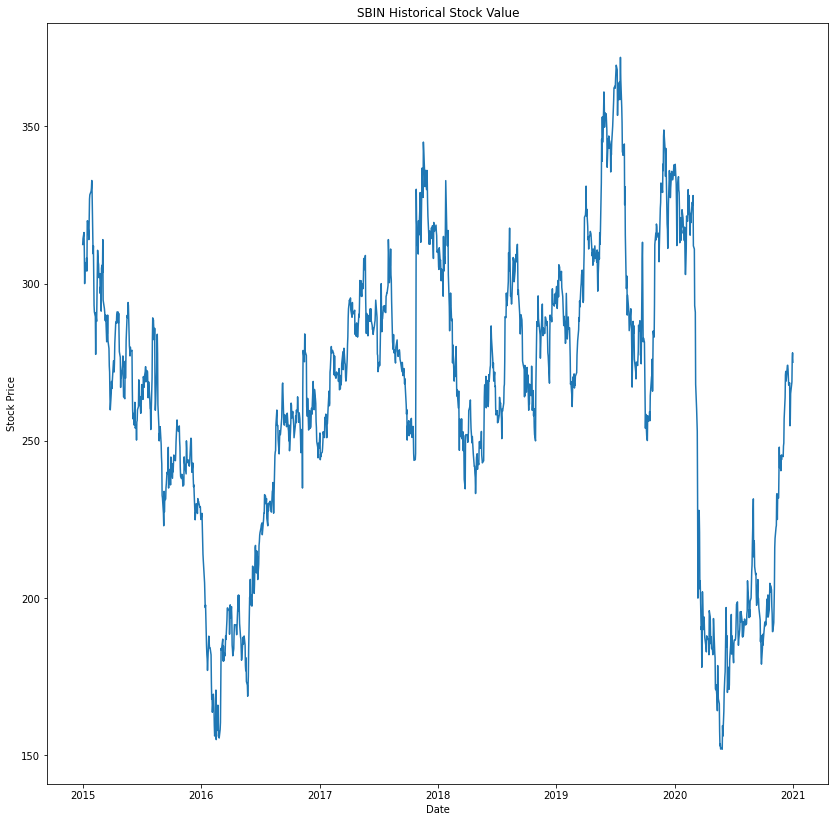

In [95]:
#Visualizing the fetched data
plt.figure(figsize=(14,14))
plt.plot(stk_data[feature_col_1])
plt.title(f'{symbol} Historical Stock Value')
plt.xlabel(date_col)
plt.ylabel('Stock Price')
plt.show()

In [96]:
#Data Preprocessing
stk_data['Date'] = stk_data.index
data2 = pd.DataFrame(columns = ['Date', 'Open'])
data2['Date'] = stk_data['Date']
data2['Open'] = stk_data['Open']


#Handling null values
data2.fillna(method='ffill', inplace=True)

train_set = data2.iloc[:, 1:2].values

sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train_set)
X_train = []
y_train = []
for i in range(n_step, len(train_set)):
    X_train.append(training_set_scaled[i-n_step:i, 0])
    y_train.append(training_set_scaled[i, 0]) 
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [97]:
X_train.shape

(1426, 60, 1)

In [98]:
model = Sequential()
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
model.add(Dense(units = 1))

In [99]:
model.compile(optimizer = optimizer, loss = loss)
model.fit(X_train, y_train, epochs = epochs, batch_size = batch_size)

Epoch 1/15
45/45 [==============================] - 18s 124ms/step - loss: 0.0476
Epoch 2/15
45/45 [==============================] - 5s 105ms/step - loss: 0.0114
Epoch 3/15
45/45 [==============================] - 5s 104ms/step - loss: 0.0114
Epoch 4/15
45/45 [==============================] - 5s 102ms/step - loss: 0.0098
Epoch 5/15
45/45 [==============================] - 5s 105ms/step - loss: 0.0090
Epoch 6/15
45/45 [==============================] - 5s 103ms/step - loss: 0.0092
Epoch 7/15
45/45 [==============================] - 5s 104ms/step - loss: 0.0075
Epoch 8/15
45/45 [==============================] - 5s 119ms/step - loss: 0.0071
Epoch 9/15
45/45 [==============================] - 5s 109ms/step - loss: 0.0063
Epoch 10/15
45/45 [==============================] - 5s 111ms/step - loss: 0.0060
Epoch 11/15
45/45 [==============================] - 5s 105ms/step - loss: 0.0066
Epoch 12/15
45/45 [==============================] - 5s 114ms/step - loss: 0.0057
Epoch 13/15
45/45 [=====

In [100]:
testdataframe= stock_hist(symbol=symbol,start=test_start_date,end=test_end_date)
testdataframe['Date'] = testdataframe.index
testdata = pd.DataFrame(columns = ['Date', 'Open'])
testdata['Date'] = testdataframe['Date']
testdata['Open'] = testdataframe['Open']

#Handling null values
testdata.fillna(method='ffill', inplace=True)

real_stock_price = testdata.iloc[:, 1:2].values
dataset_total = pd.concat((data2['Open'], testdata['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(testdata) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(n_step, len(inputs)):
    X_test.append(inputs[i-n_step:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [101]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

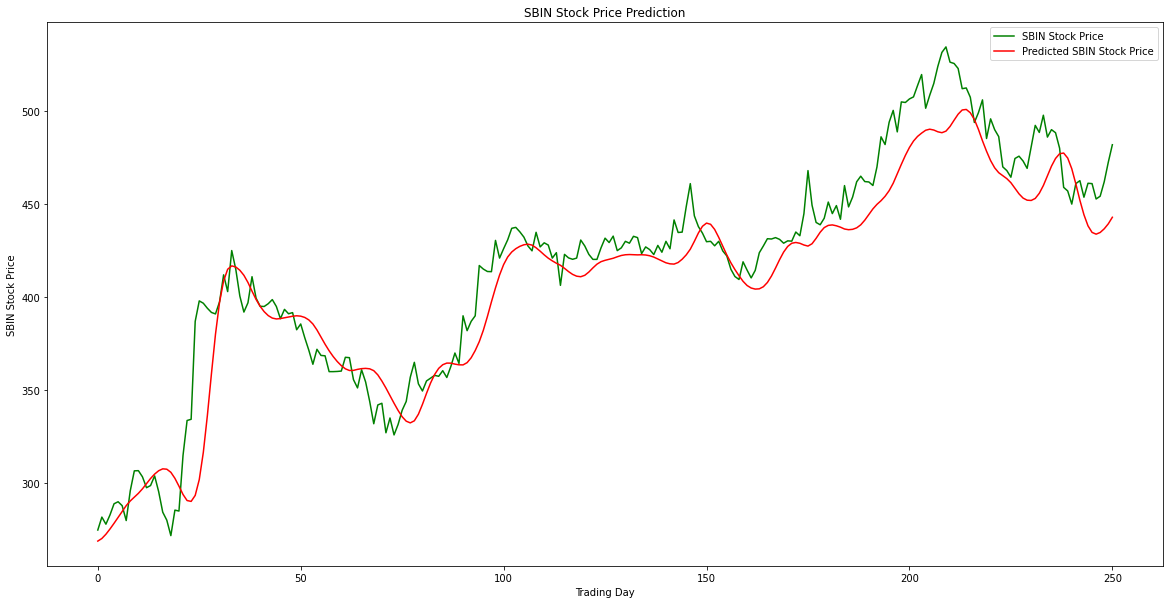

In [102]:
plt.figure(figsize=(20,10))
plt.plot(real_stock_price, color = 'green', label = f'{symbol} Stock Price')
plt.plot(predicted_stock_price, color = 'red', label = f'Predicted {symbol} Stock Price')
plt.title(f'{symbol} Stock Price Prediction')
plt.xlabel('Trading Day')
plt.ylabel(f'{symbol} Stock Price')
plt.legend()
plt.show()